## R Notebook File

In [ ]:
install.packages('remotes')
library(remotes)

install_github("wesleyburr/tsinterp")
install_github("castels/interpTools")
install_github('rstudio/tensorflow')
install.packages('keras')

In [10]:
library(remotes)
library(tsinterp)
library(interpTools)
library(tensorflow)
library(keras)

Warning message in simMt(N = N, numTrend = numTrend, a = a, mu = mu, center = center):
“Value(s): 'a, center, ' unspecified. Defaulting to random generation. 
”
Warning message in simMt(N = N, numTrend = numTrend, a = a, mu = mu, center = center):
“Polynomial coefficient(s) = 6.855  
”
Warning message in simMt(N = N, numTrend = numTrend, a = a, mu = mu, center = center):
“Centering parameter = 65 
”
Warning message in simTt(N = N, numFreq = numFreq, bandwidth = bandwidth, b = b, :
“Value(s): 'b, w, ' unspecified. Defaulting to random generation. 
”
Warning message in simTt(N = N, numFreq = numFreq, bandwidth = bandwidth, b = b, :
“Sinusoid coefficient(s) = 0.478 0.024  
”
Warning message in simTt(N = N, numFreq = numFreq, bandwidth = bandwidth, b = b, :
“bandwidth not specified- frequencies will be selected randomly from Uniform(a=0,b=1); 
”
Warning message in simTt(N = N, numFreq = numFreq, bandwidth = bandwidth, b = b, :
“Sinusoid period(s) = 0.477 2.086  
”


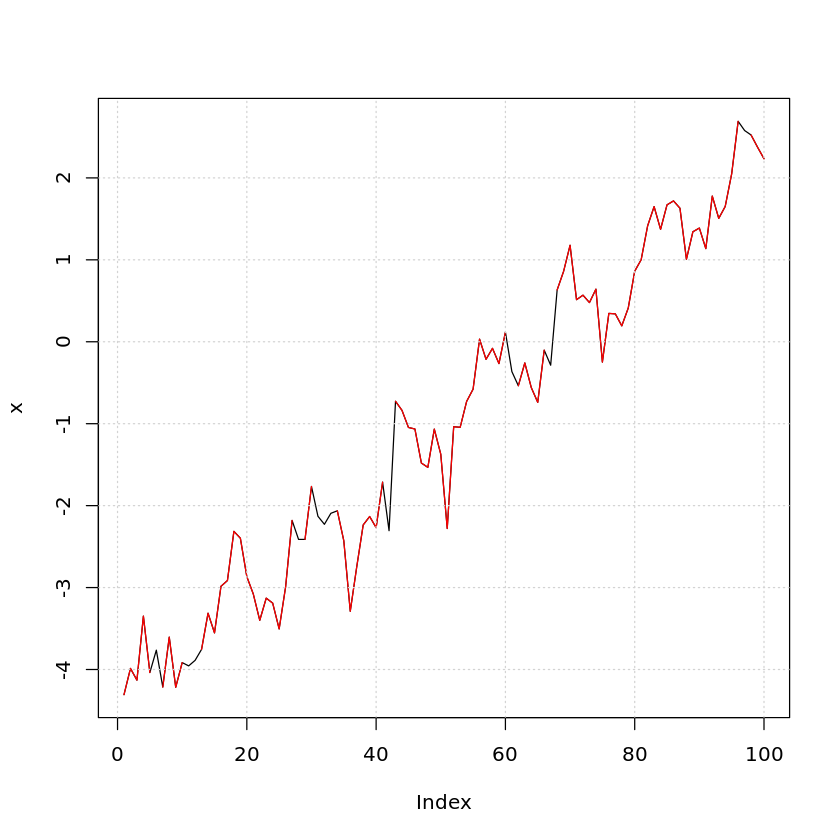

In [12]:
set.seed(42)

## Simulating the truth time series and imposing gap structure
x = simXt(N = 100, mu = 0, numTrend = 1, numFreq = 2)$Xt
x_gappy = simulateGaps(list(x), p = 0.1, g = 1, K = 1)[[1]]$p0.1$g1[[1]]

plot(x, type = 'l', col = 'black')
lines(x_gappy, type = 'l', col = 'red')
grid()

#### Testing Work

In [15]:
testb = nn_imputer(x_gappy, max_iter = 1, size = 20, p = 0.05, g = 1)

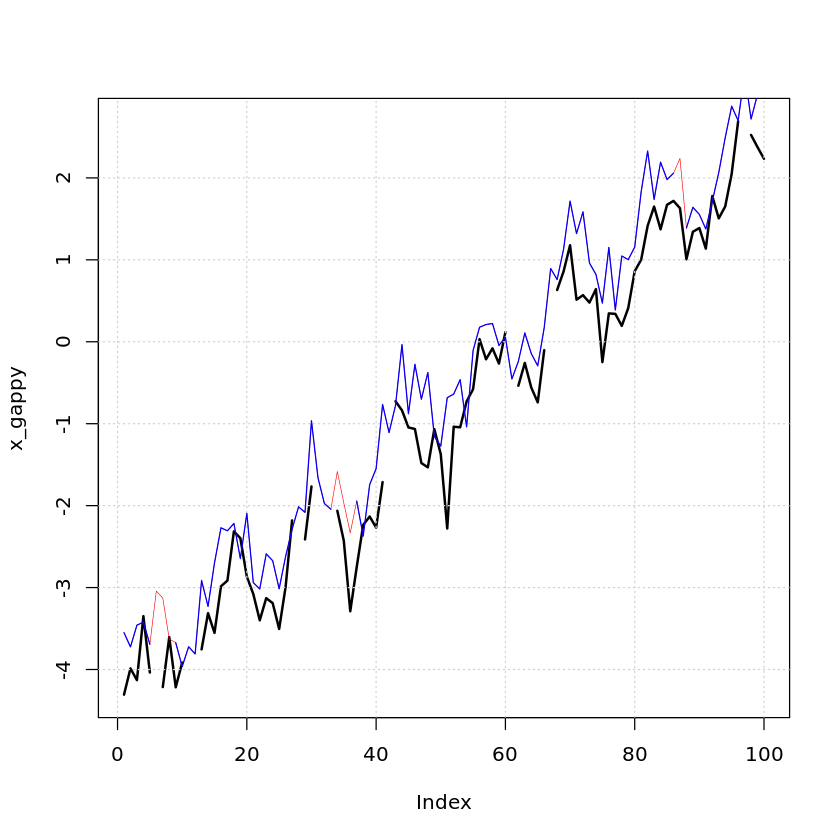

In [19]:
plot(x_gappy, type = 'l', lwd = 2); grid(); 
lines(testb[[2]][1,], type = 'l', col = 'red', lwd = 0.5)
lines(testb[[1]][1,], type = 'l', col = 'blue')

In [21]:
autoencoder = keras_model_sequential(name = 'Autoencoder') %>%
  layer_masking(mask_value = 0, input_shape = c(100)) %>%
  layer_dense(units = 32, activation = 'relu', name = 'encoder') %>%
  layer_dense(units = 100, activation = 'sigmoid', name = 'decoder')

autoencoder %>% compile(
  optimizer = 'adam',
  loss = 'binary_crossentropy')

In [22]:
autoencoder

Model: "Autoencoder"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 masking (Masking)                  (None, 100)                     0           
 encoder (Dense)                    (None, 32)                      3232        
 decoder (Dense)                    (None, 100)                     3300        
Total params: 6,532
Trainable params: 6,532
Non-trainable params: 0
________________________________________________________________________________

#### Defining Functions

In [13]:
initialize <- function(x_gappy){
  
  ## Saving the index of gapped points
  gap = which(is.na(x_gappy) == TRUE)

  ## Identifying gap structure
  gapTrue = rep(NA, length(x_gappy))
  gapTrue[-gap] = TRUE
  
  ## Finding blocks of missing points
  blocks = tsinterp::findBlocks(gapTrue)
  
  ## Initial imputation using linear interpolation approach
  x0 = x_gappy
  xI = linInt(x0, blocks)
  return(xI)
}


estimator <- function(x, delT, sigClip){
  
  ## Estimating trend and periodic components
  Mt = estimateMt(x = x, N = length(x), nw = 5, k = 8, pMax = 2)
  Tt = estimateTt(x = x - Mt, epsilon = 1e-6, dT = delT, nw = 5, k = 8, sigClip = sigClip)
  
  return(Mt + Tt)
}


data_generator <- function(x, n_series, var, p, g, K){
  
  N = length(x)
  M = n_series * K
  inputs_temp = c()
  targets_temp = c()
  
  for (i in 1:n_series){
    
    x_p = x + rnorm(1, 0, var) + rnorm(N, 0, var)
    x_g = simulateGaps(list(x_p), p = p, g = g, K = K)
    
    for (k in 1:K){
      structure = paste0('x_g[[1]]$p', p, '$g', g, '[[k]]')
      inputs_temp = c(inputs_temp, eval(parse(text = structure)))
      targets_temp = c(targets_temp, x_p)
    }
  }
  inputs = array(matrix(inputs_temp, nrow = M, byrow = TRUE), dim = c(M, N))
  targets = array(matrix(targets_temp, nrow = M, byrow = TRUE), dim = c(M, N))
  
  return(list(inputs, targets))
}


impute <- function(inputs, targets, mask_value){
  
  N = dim(inputs)[2]
  
  ## Constructing and compiling the model
  autoencoder = keras_model_sequential(name = 'Autoencoder') %>%
    layer_masking(mask_value = mask_value, input_shape = c(N)) %>%
    layer_dense(units = 32, activation = 'relu', name = 'encoder') %>%
    layer_dense(units = N, activation = 'sigmoid', name = 'decoder')
  
  autoencoder %>% compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy')
  
  ## Fitting the model to the training data
  autoencoder %>% fit(inputs, targets, epochs = 25, batch_size = 32, 
                      shuffle = FALSE, validation_split = 0.2)
  
  ## Predicting on the testing set
  preds = autoencoder %>% predict(inputs)
  
  return(preds)
}



nn_imputer <- function(x0, max_iter, size, p, g){
  
  ## Initialize the imputation problem
  xI = initialize(x0)
  
  ## 
  for (i in 1:max_iter){
    
    ## Getting an estimate for trend and periodic components
    xI = estimator(xI, delT = 1, sigClip = 0.999)
    
    ## Generating training data
    data = data_generator(xI, n_series = size, var = 0.25, p = p, g = g, K = 5)
    inputs = data[[1]]; targets = data[[2]]
    
    ## Building neural network
    #preds = impute(inputs, targets, mask_value = NA)
  }
  return(list(inputs, targets))
}

In [14]:
#############################
## Functions from TSimpute ##
#############################

## Defining function to estimate trend component
estimateMt <- function(x, N, nw, k, pMax) {
  V <- dpss(n = N, nw = 5, k = 8)$v
  test <- dpssap(V, pMax) # fit quadratic
  U <- test[[1]]
  R <- test[[2]]
  Y <- t(V) %*% x
  a <- t(U) %*% Y
  r <- Y - U %*% a
  xhat <- V %*% r + R %*% a
  phat <- R %*% a
  return(phat)
}

## Defining function to estimate periodic component
estimateTt <- function(x, epsilon, dT, nw, k, sigClip, progress=FALSE, freqIn=NULL) {
  
  ################################################################################
  # Algorithm step 1: spectrum/Ftest pilot estimate
  pilot <- spec.mtm(x, deltat=dT, nw=nw, k=k, Ftest=TRUE, plot=FALSE)
  
  if(is.null(freqIn)) {
    ################################################################################
    # Algorithm step 2: estimate significant peaks (sigClip)
    fmesh <- pilot$mtm$Ftest
    fsig <- fmesh > qf(sigClip, 2, pilot$mtm$k)
    floc <- which(fsig==TRUE)
    if(length(floc > 0)) {
      ###########################################################################   
      delta <- floc[2:length(floc)] - floc[1:(length(floc)-1)]
      if(length(which(delta==1)) > 0) {
        bad <- which(delta==1)
        if(!is.null(bad)) {
          if(progress) {
            for(j in 1:length(bad)) {
              cat(paste("Peak at ", formatC(pilot$freq[floc[bad[j]]], width=6, format="f"),
                        "Hz is smeared across more than 1 bin. \n", sep=""))
            } 
          }
        }
        floc <- floc[-bad] # eliminate the duplicates
      }
      
      ################################################################################
      # Algorithm step 3: estimate centers
      dFI <- pilot$freq[2]
      # epsilon <- 1e-10
      maxFFT <- 1e20
      max2 <- log(maxFFT, base=2)
      max3 <- log(maxFFT, base=3)
      max5 <- log(maxFFT, base=5)
      max7 <- log(maxFFT, base=7)
      
      freqFinal <- matrix(data=0, nrow=length(floc), ncol=1)
      
      for(j in 1:length(floc)) {
        if(progress) {
          cat(".")  
        }
        f0 <- pilot$freq[floc[j]]
        
        if(progress) {
          cat(paste("Optimizing Peak Near Frequency ", f0, "\n", sep=""))
        }
        
        # increasing powers of 2,3,5,7 on nFFT until peak estimate converges
        pwrOrig <- floor(log2(pilot$mtm$nFFT)) + 1
        fI <- f0
        converge <- FALSE
        
        for(k7 in 0:max7) {
          for(k5 in 0:max5) {
            for(k3 in 0:max3) {
              for(k2 in 1:max2) {
                
                if(!converge) {
                  nFFT <- 2^pwrOrig * 2^k2 * 3^k3 * 5^k5 * 7^k7
                  tmpSpec <- spec.mtm(x, deltat=dT, nw=5, k=8, plot=FALSE, Ftest=TRUE,
                                      nFFT=nFFT)
                  dF <- tmpSpec$freq[2]
                  f0loc <- which(abs(tmpSpec$freq - f0) <= dF)
                  range <- which(tmpSpec$freq <= (f0+1.1*dFI) & tmpSpec$freq >= (f0-1.1*dFI))
                  
                  fI2 <- tmpSpec$freq[which(tmpSpec$mtm$Ftest == max(tmpSpec$mtm$Ftest[range]))]
                  if(abs(fI - fI2) > epsilon) {
                    fI <- fI2
                  } else {
                    fF <- fI2
                    converge <- TRUE
                  }
                }
              }}}}
        freqFinal[j] <- fF
        if(progress) {
          cat(paste("Final frequency estimate: ", fF, "\n", sep=""))
        }
      }
      if(progress) {
        cat("\n")
      }
    } else {
      freqFinal <- NULL
      floc <- -1
    } # end of "there are freqs detected"
  } else {  # case where frequencies are already obtained
    freqFinal <- freqIn
    floc <- 1:length(freqFinal)
    if(length(freqFinal)==1 & freqFinal[1]==0) {
      floc <- -1
    }
  }
  ################################################################################
  # Algorithm step 4: frequencies obtained, estimate phase and amplitude
  #    by inverting the spectrum (i.e. line component removal)
  if(length(floc) > 1 | floc[1] > 0) {
    sinusoids <- matrix(data=0, nrow=length(x), ncol=length(floc))
    amp <- matrix(data=0, nrow=length(floc), ncol=1)
    phse <- matrix(data=0, nrow=length(floc), ncol=1)
    N <- length(x)
    t <- seq(1, N*dT, dT)
    
    for(j in 1:length(floc)) {
      sinusoids[, j] <- removePeriod(x, freqFinal[j], nw=5, k=8, deltaT=dT, warn=FALSE, prec=1e-10, sigClip=sigClip) 
      fit <- lm(sinusoids[, j] ~ sin(2*pi*freqFinal[j]*t) + cos(2*pi*freqFinal[j]*t) - 1)
      phse[j] <- atan(fit$coef[2] / fit$coef[1])
      amp[j] <- fit$coef[1] / cos(phse[j])
    }
    
    attr(sinusoids, "Phase") <- phse
    attr(sinusoids, "Amplitude") <- amp
    attr(sinusoids, "Frequency") <- freqFinal
    return(sinusoids)
  } else {
    sinusoids <- matrix(data=0, nrow=length(x), ncol=length(floc))
    attr(sinusoids, "Phase") <- 0
    attr(sinusoids, "Amplitude") <- 0
    attr(sinusoids, "Frequency") <- 0
    return(sinusoids)
  }
}


## Defining helper functions
dpssap <- function(V, maxdeg) {
  
  # Sanity checks
  stopifnot(is.matrix(V), is.numeric(maxdeg), maxdeg>=0)
  N <- length(V[, 1])
  K <- length(V[1, ])
  P <- maxdeg + 1
  timeArr <- 1:N
  
  R <- matrix(data=0, nrow=N, ncol=P)
  U <- matrix(data=0, nrow=K, ncol=P)
  
  # Setup centered time index
  midTime <- (1+N) / 2
  scl <- 2/(N-1)
  timeArrC <- (timeArr - midTime) * scl
  
  # Start with Gegenbauer polynomials; convergence is faster
  alpha <- 0.75
  R[, 1] <- 1.0
  if(maxdeg > 0) {
    R[, 2] <- 2 * alpha * timeArrC
    if(maxdeg > 1) {
      for(j in 2:maxdeg) {
        A1 <- 2 * ( (j-1) + alpha ) / j
        A2 <- ( (j-2) + 2 * alpha ) / j
        
        R[, (j+1)] <- A1 * timeArrC * R[, j] - A2 * R[, (j-1)]
      } # end of loop on higher orders
    } # end of maxdeg > 1
  } # end of maxdeg > 0
  
  # Inner Products of R and V
  for(L in 1:P) {
    Kmin <- ( (L-1) %% 2 ) + 1
    for(k in seq(Kmin, K, 2)) {  # loop on non-zero Slepians
      U[k, L] <- t(V[, k]) %*% R[, L]
    }
  }
  
  # Degree 0, 1 (manual) -- L = degree+1
  for(L in 1:min(2,P)) {
    scl <- 1 / sqrt( sum(U[, L]^2) )
    U[, L] <- U[, L] * scl # orthonormalize
    R[, L] <- R[, L] * scl
  }
  
  # loop on higher degrees, applying Gram-Schmidt only on similar
  # parity functions (as even/odd are already orthogonal in U)
  if( P > 2 ) {
    for(L in 3:P) {
      if(L %% 2 == 0) {
        Kmin <- 2
      } else {
        Kmin <- 1
      }
      for(j in seq(Kmin, L-1, 2)) {
        scl <- sum( U[, L] * U[, j] )
        U[, L] <- U[, L] - scl * U[, j] # Gram-Schmidt
        R[, L] <- R[, L] - scl * R[, j]
      }
      scl <- 1 / sqrt(sum(U[, L]^2))
      U[, L] <- U[, L] * scl  # orthonormalize
      R[, L] <- R[, L] * scl
    }
  }
  
  Hn <- colSums(R^2)
  return(list(U,R,Hn))
}


removePeriod <- function(xd, f0, nw, k, deltaT, warn=FALSE, prec=1e-10, sigClip) {
  
  # xd : data
  # f0 : freq of periodicty to remove
  # nw, k : parameters of multitaper
  # deltaT : parameter of xd
  # prec.st : starting precision for finding a good nFFT for removal
  
  # check to make sure f0 is reasonable, otherwise warn
  N <- length(xd)
  spec.t <- spec.mtm(xd,nw=nw,k=k,Ftest=T,plot=F,nFFT=2^(floor(log(N,2))+2),deltat=deltaT)
  idx <- max(which(spec.t$freq < f0))
  if( max(spec.t$mtm$Ftest[idx],spec.t$mtm$Ftest[idx]) < qf(sigClip,2,(2*k-2)) && warn ) {
    warning("Ftest at frequency f0 not significant. Are you sure you want to remove this?")
  }
  
  # early parameter setup, find a nFFT that gives a bin *very* close to f0, or on top of it
  Nyq <- 1/2/deltaT
  nFFT <- -1
  prec.st <- prec
  while( nFFT < 0 ) {
    nFFT <- findPowers(N,f0,Nyq,prec.st)
    prec.st <- prec.st*10
  }
  
  spec <- spec.mtm(xd,nw=nw,k=k,returnInternals=T,Ftest=T,plot=F,nFFT=nFFT,maxAdaptiveIterations=0,
                   deltat=deltaT)
  
  # parameter setup
  w <- nw/N/deltaT
  df <- 1/nFFT/deltaT
  neh <- max(10,(floor((2*w)/df+1)))
  f0.idx <- seq(along=spec$freq)[spec$freq == (f0 - min(abs(spec$freq - f0))) | spec$freq == (f0 + min(abs(spec$freq - f0)))]
  
  ##########################################################################
  # 
  #  All spectral window work will require the full spectral array
  # 
  ##########################################################################
  # form spectral windows
  dw <- dpss(N,k,5.0)$v*sqrt(deltaT)
  # zero-pad
  dw.z <- rbind(dw,matrix(data=0,nrow=(spec$mtm$nFFT-N),ncol=k))
  # empty window array, nFFT x k
  sw <- matrix(data=0,nrow=spec$mtm$nFFT,ncol=k)
  for(j in 1:k) {
    ft <- fft(dw.z[,j])
    sw[,j] <- c(ft[(spec$mtm$nfreqs+1):spec$mtm$nFFT],ft[1:spec$mtm$nfreqs])
  }
  
  # form estimate of chosen frequency component - takes 0+/- neh from the spectral
  #   window and expands it by multiplying by the CMV at f0
  est <- matrix(data=complex(0,0),nrow=(2*neh+1),ncol=k)
  for(j in 1:k) {
    est[,j] <- spec$mtm$cmv[f0.idx]*(sw[((spec$mtm$nfreqs-1)-neh):((spec$mtm$nfreqs-1)+neh),j])
  }
  
  # subtract from original eigencoefficients
  egn <- spec$mtm$eigenCoefs
  egn <- rbind(Conj(egn[2:spec$mtm$nfreqs,]), egn)
  range <- (f0.idx-neh+spec$mtm$nfreqs) : (f0.idx+neh+spec$mtm$nfreqs)
  if(max(range) > nFFT) {
    # case of folding over the top, i.e. freq too close to Nyq+
    fold <- which(range > nFFT)
    rangeF <- range[fold]
    rangeN <- range[-fold]
    range <- c(1:length(rangeF), rangeN)
  } 
  est2 <- est
  for(j in 1:k) {
    est2[which(range < spec$mtm$nfreqs),j] <- Conj(est2[which(range < spec$mtm$nfreqs),j])
    egn[range,j] <- egn[range,j] - est2[,j]
  }
  
  blank <- matrix(data=0,nrow=nFFT,ncol=1)
  blank[f0.idx] <- spec$mtm$cmv[f0.idx]
  blank[nFFT-f0.idx+2] <- Conj(spec$mtm$cmv[f0.idx])
  inv <- fft(blank,inverse=T)
  inv <- Re(inv)[1:N]
  
  #  cat(paste("Freq: ", spec$freq[f0.idx]," \n",
  #            "Amp : ", sqrt(Mod(spec$mtm$cmv[f0.idx])), "\n",
  #            "Phse: ", Arg(spec$mtm$cmv[f0.idx]), "\n", sep=""))
  return(inv)
}


findPowers <- function(N,f0,Nyq,prec) {
  nFFT <- 1e30
  
  low2 <- 0
  high2 <- floor(log(N,2))+2
  low3 <- 0
  high3 <- floor(log(N,3))+2
  low5 <- 0
  high5 <- floor(log(N,5))+2
  low7 <- 0
  high7 <- floor(log(N,7))+2
  for(i in low2:high2) {
    for(j in low3:high3) {
      for(k in low5:high5) {
        for(l in low7:high7) {
          att <- 2^i * 3^j * 5^k * 7^l
          if((att > 2*N) & att < 100*N) {
            df <- (Nyq*2)/att
            if( abs(trunc(f0/df)*df - f0) < prec ) {
              if(att < nFFT) {
                nFFT <- att 
              }
            }
          } # big enough
        } # end of 7
      } # end of 5
    } # end of 3
  } # end of 2
  if(nFFT == 1e30) {
    return(-1)
  } else {
    return(nFFT)
  }
}